In [1]:
import numpy as np
import pandas as pd
import os
import sys

from utils import select_ores_greedy
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
# %matplotlib inline

import pickle
import cv2
from scipy.stats import pearsonr

import importlib
# from classifiers import R_from_path
%config InlineBackend.figure_format = 'png' 

In [2]:
pd.options.mode.chained_assignment = None  # 默认是'warn'
from classifiers.r_method import RMethodClassifier

In [10]:
with open('input_0219_0224_0225.pkl', 'rb') as f:
    input_all = pickle.load(f)
pixels = input_all[0]
data = input_all[1]

In [14]:
data.loc[351]

Sample No.          148
Fe_grade           14.7
Zn_grade          22.38
Pb_grade          11.93
S_grade             0.0
weight             29.1
source         source_2
Zn_Pb_grade       34.31
Name: 351, dtype: object

In [21]:
import pandas as pd
import numpy as np

def select_ores_U_shape(df, N, target_grade, max_iter=1000, balance=0.5):
    """
    选择N块矿石，使加权平均Pb+Zn品位接近目标值 target_grade，
    同时矿石的品位分布尽量呈 U 型（低和高的多，中间少）
    
    参数:
    - df: pandas.DataFrame, 包含列 'weight', 'Pb_grade', 'Zn_grade'
    - N: int, 要选的矿石数量
    - target_grade: float, 目标加权平均Pb+Zn品位
    - max_iter: int, 最大交换次数
    - balance: float, [0, 1]，控制“分布离散性”和“目标品位接近度”的权重
               0 → 只追求目标品位；1 → 只追求U型分布
    
    返回:
    - selected: pandas.DataFrame, 选中的矿石子集
    """
    df = df.copy()
    df['grade'] = df['Pb_grade'] + df['Zn_grade']
    
    # u_score 越大，表示该矿石品位越远离目标 → 我们越喜欢
    df['u_score'] = (df['grade'] - target_grade)**2

    # 初始选择：选u_score最高的N个矿石（最远离目标）
    selected = df.nlargest(N, 'u_score').copy()
    rest = df.drop(selected.index).copy()

    def calc_weighted_avg(s_df):
        total_weight = s_df['weight'].sum()
        return (s_df['grade'] * s_df['weight']).sum() / total_weight

    def calc_combined_score(s_df):
        avg_diff = abs(calc_weighted_avg(s_df) - target_grade)
        u_shape_score = s_df['u_score'].sum()
        # 目标函数：平衡两者
        return balance * (-u_shape_score) + (1 - balance) * avg_diff * 1000

    best_score = calc_combined_score(selected)

    for _ in range(max_iter):
        improved = False
        for i in selected.index.copy():
            if improved:
                break
            for j in rest.index.copy():
                new_selected = pd.concat([selected.drop(i), rest.loc[[j]]])
                new_score = calc_combined_score(new_selected)
                if new_score < best_score:
                    # 替换成功
                    
                    rest = pd.concat([rest.drop(j), selected.loc[[i]]])
                    selected = new_selected
                    
                    best_score = new_score
                    improved = True
                    break
        if not improved:
            break

    print(f"目标品位: {target_grade:.4f}, 实际加权: {calc_weighted_avg(selected):.4f}")
    return selected.drop(columns=['u_score', 'grade'])


import pandas as pd
import numpy as np

def select_ores_u2(df, N, target_grade, max_iter=1000, alpha=1.0):
    """
    修改后的贪心算法，选择矿石使其品位呈U型分布
    
    参数:
    - df: pandas.DataFrame, 包含列: 'weight', 'Pb_grade', 'Zn_grade'
    - N: int, 需要选择的矿石数量
    - target_grade: float, 目标(Pb+Zn)加权平均品位
    - max_iter: int, 最大迭代次数
    - alpha: float, 控制U型分布强度的参数，越大则高低品位矿石越优先
    
    返回:
    - selected_df: pandas.DataFrame, 选中的矿石数据
    """
    
    df = df.copy()
    df['total_grade'] = df['Pb_grade'] + df['Zn_grade']
    
    # 计算每块矿石与目标品位的距离，并添加U型偏好
    # 使用alpha参数控制U型分布的强度
    df['delta'] = (abs(df['total_grade'] - target_grade)) ** alpha
    
    # 初始选择：delta最大的N块矿石（优先选择高低品位的）
    selected = df.nlargest(N, 'delta').copy()
    rest = df.drop(selected.index).copy()
    
    def calc_avg(s_df):
        total_weight = s_df['weight'].sum()
        return ((s_df['Pb_grade'] * s_df['weight']).sum() + 
                (s_df['Zn_grade'] * s_df['weight']).sum()) / total_weight
    
    current_avg = calc_avg(selected)
    best_diff = abs(current_avg - target_grade)
    
    for _ in range(max_iter):
        improved = False
        
        # 按品位排序选中的矿石，便于后续调整
        selected_sorted = selected.sort_values('total_grade')
        
        # 尝试用高品位或低品位矿石替换中间品位的矿石
        for i in selected_sorted.index[N//10:9*N//10]:  # 主要替换中间50%的矿石
            if improved:
                break
                
            # 优先考虑rest中品位最高和最低的矿石
            rest_sorted = rest.sort_values('total_grade')
            candidates = pd.concat([rest_sorted.head(20), rest_sorted.tail(20)])
            
            for j in candidates.index:
                try:
                    # 尝试交换i和j
                    new_selected = pd.concat([
                        selected.drop(i),
                        rest.loc[[j]]
                    ])
                    new_avg = calc_avg(new_selected)
                    new_diff = abs(new_avg - target_grade)
                    
                    if new_diff < best_diff:
                        # 更新rest：移除j，添加i
                        new_rest = pd.concat([
                            rest.drop(j),
                            selected.loc[[i]]
                        ])
                        
                        selected = new_selected
                        rest = new_rest
                        best_diff = new_diff
                        improved = True
                        break
                except KeyError as e:
                    print(f"交换时出错：{e}，跳过此次交换")
                    continue
        if not improved:
            break
    
    # 最终验证和输出
    final_avg = calc_avg(selected)
    print(f"目标品位: {target_grade:.4f}, 实际得到: {final_avg:.4f}")
    
    # 分析分布情况
    selected['total_grade'] = selected['Pb_grade'] + selected['Zn_grade']
    print("\n品位分布统计:")
    print(selected['total_grade'].describe())
    
    # 绘制简单的分布直方图
    try:
        import matplotlib.pyplot as plt
        plt.hist(selected['total_grade'], bins=20)
        plt.title("Selected Grades Distribution")
        plt.xlabel("Pb+Zn Grade")
        plt.ylabel("Count")
        plt.show()
    except ImportError:
        pass
    
    return selected.drop(columns=['delta', 'total_grade'])


目标品位: 1.0000, 实际得到: 9.0329

品位分布统计:
count    100.00000
mean       5.99162
std       17.54479
min        0.01200
25%        0.09250
50%        0.19100
75%        0.31725
max       64.93000
Name: total_grade, dtype: float64


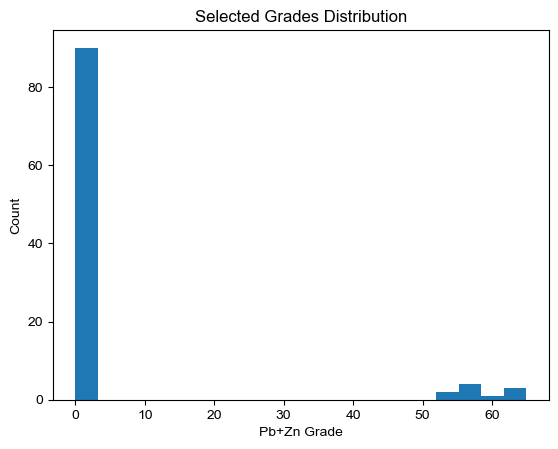

In [22]:
selected_u = select_ores_u2(data, 100, 1)

In [ ]:
grades = selected_u['Pb_grade'] + selected_u['Zn_grade']

plt.hist(grades, bins=15, edgecolor='black')
plt.axvline(x=0.12, color='red', linestyle='--', label='Target Grade')
plt.title('Selected Ore Grade Distribution (U-shape expected)')
plt.xlabel('Pb + Zn grade')
plt.ylabel('Count')
plt.legend()
plt.show()

In [112]:
index_0219 = data.loc[data['source'] == 'source_0'].index.values
input_0219 = [[pixels[0][index_0219], pixels[1][index_0219]], data.loc[index_0219]]
weight = input_0219[1]['weight']
zn = input_0219[1]['Zn_grade']*weight
pb = input_0219[1]['Pb_grade']*weight
fe = input_0219[1]['Fe_grade']*weight
sg = input_0219[1]['S_grade']*weight

R_0219 = RMethodClassifier(pixels=input_0219[0], truth=input_0219[1], I0_low=195, I0_high=196, input='pixels', method='a', const=[5, 20])

In [204]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable  # 新增导入
from scipy.stats import gaussian_kde, spearmanr

def plot_dist(inputs, type = 'intensity', kind = 'pearsonr', energy = 'high', w = False): # = [input_0225, input_0219]
    for data in inputs:
        fig, axes = plt.subplots(3, 2, figsize=(12, 15))
        if w:
            weight = data[1]['weight']
        else:
            weight = 1
        zn = data[1]['Zn_grade']*weight
        pb = data[1]['Pb_grade']*weight
        fe = data[1]['Fe_grade']*weight
        zn_pb = zn + pb
        zn_pb_fe = zn + pb + fe
        R_0219 = RMethodClassifier(pixels=data[0], truth=data[1], I0_low=195, I0_high=196, input='pixels', method='a', const=[5, 20])
        if type == 'intensity':
            if energy == 'high':
                R_mean = R_0219.pixels[1].apply(np.mean)
            elif energy == 'low':
                R_mean = R_0219.pixels[0].apply(np.mean)

        elif type == 'log':
            if energy == 'high':            
                R_mean = R_0219.pixels[1].apply(lambda x: np.log(195/(x + 1e-6))).apply(np.mean)
            elif energy == 'low':
                R_mean = R_0219.pixels[0].apply(lambda x: np.log(196/(x + 1e-6))).apply(np.mean)

        data_pairs = [(zn, R_mean), (pb, R_mean), (zn_pb, R_mean), (zn_pb_fe, R_mean), (fe, R_mean)]
        labels = ['zn', 'pb', 'zn_pb', 'zn_pb_fe', 'fe']
        marker_size = 5
        
        for i, (ax, (x, y), label) in enumerate(zip(axes.flat, data_pairs, labels)):

            # 绘制主散点图
            ax.scatter(x, y, s=marker_size)
            if kind == 'pearsonr':
                corr, p = pearsonr(x, y)
            elif kind == 'spearmanr':
                corr, p = spearmanr(x, y)
            ax.set_title(f'ln(I0/I)_mean_{energy} vs {label}\n{kind} r: {corr:.2f}, p: {p:.2e}')
            ax.set_xlabel(label)
            # ax.set_ylabel('R_mean')

            print(f'ln(I0/I)_mean_{energy} vs {label}\n{kind} r: {corr:.2f}, p: {p:.2e}')

            # 创建嵌入的小图
            axins = inset_axes(ax, width="30%", height="40%", loc='lower right')
            mask = (x >= 0) & (x <= 3)
            x_zoom = x[mask]
            y_zoom = y[mask]
            axins.scatter(x_zoom, y_zoom, s=marker_size)
            axins.set_xlim(-0.5, 3)

            # 新增：创建密度分布图
            divider = make_axes_locatable(ax)
            ax_density = divider.append_axes("bottom", size=0.2, pad=0.25, sharex=ax)
            kde = gaussian_kde(x)
            x_vals = np.linspace(x.min(), x.max(), 100)
            density = kde(x_vals)
            
            # 绘制密度曲线并填充
            ax_density.plot(x_vals, density, color='#1f77b4', lw=1)
            # ax_density.fill_between(x_vals, density, color='#1f77b4', alpha=0.4)
            
            # 反转y轴并调整格式
            ax_density.invert_yaxis()
            ax_density.set_yticks([])
            ax_density.xaxis.set_visible(False)  # 隐藏x轴
            ax_density.spines['top'].set_visible(False)
            # ax_density.spines['right'].set_visible(False)
            ax_density.spines['bottom'].set_visible(False)

        axes[2, 1].axis('off')

        # 调整布局避免重叠
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.tight_layout()
        plt.show()

ln(I0/I)_mean_high vs zn
spearmanr r: 0.64, p: 1.97e-45
ln(I0/I)_mean_high vs pb
spearmanr r: 0.79, p: 5.49e-83
ln(I0/I)_mean_high vs zn_pb
spearmanr r: 0.76, p: 4.40e-74
ln(I0/I)_mean_high vs zn_pb_fe
spearmanr r: 0.90, p: 1.03e-138
ln(I0/I)_mean_high vs fe
spearmanr r: 0.63, p: 7.63e-44


/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_9987/2405081674.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


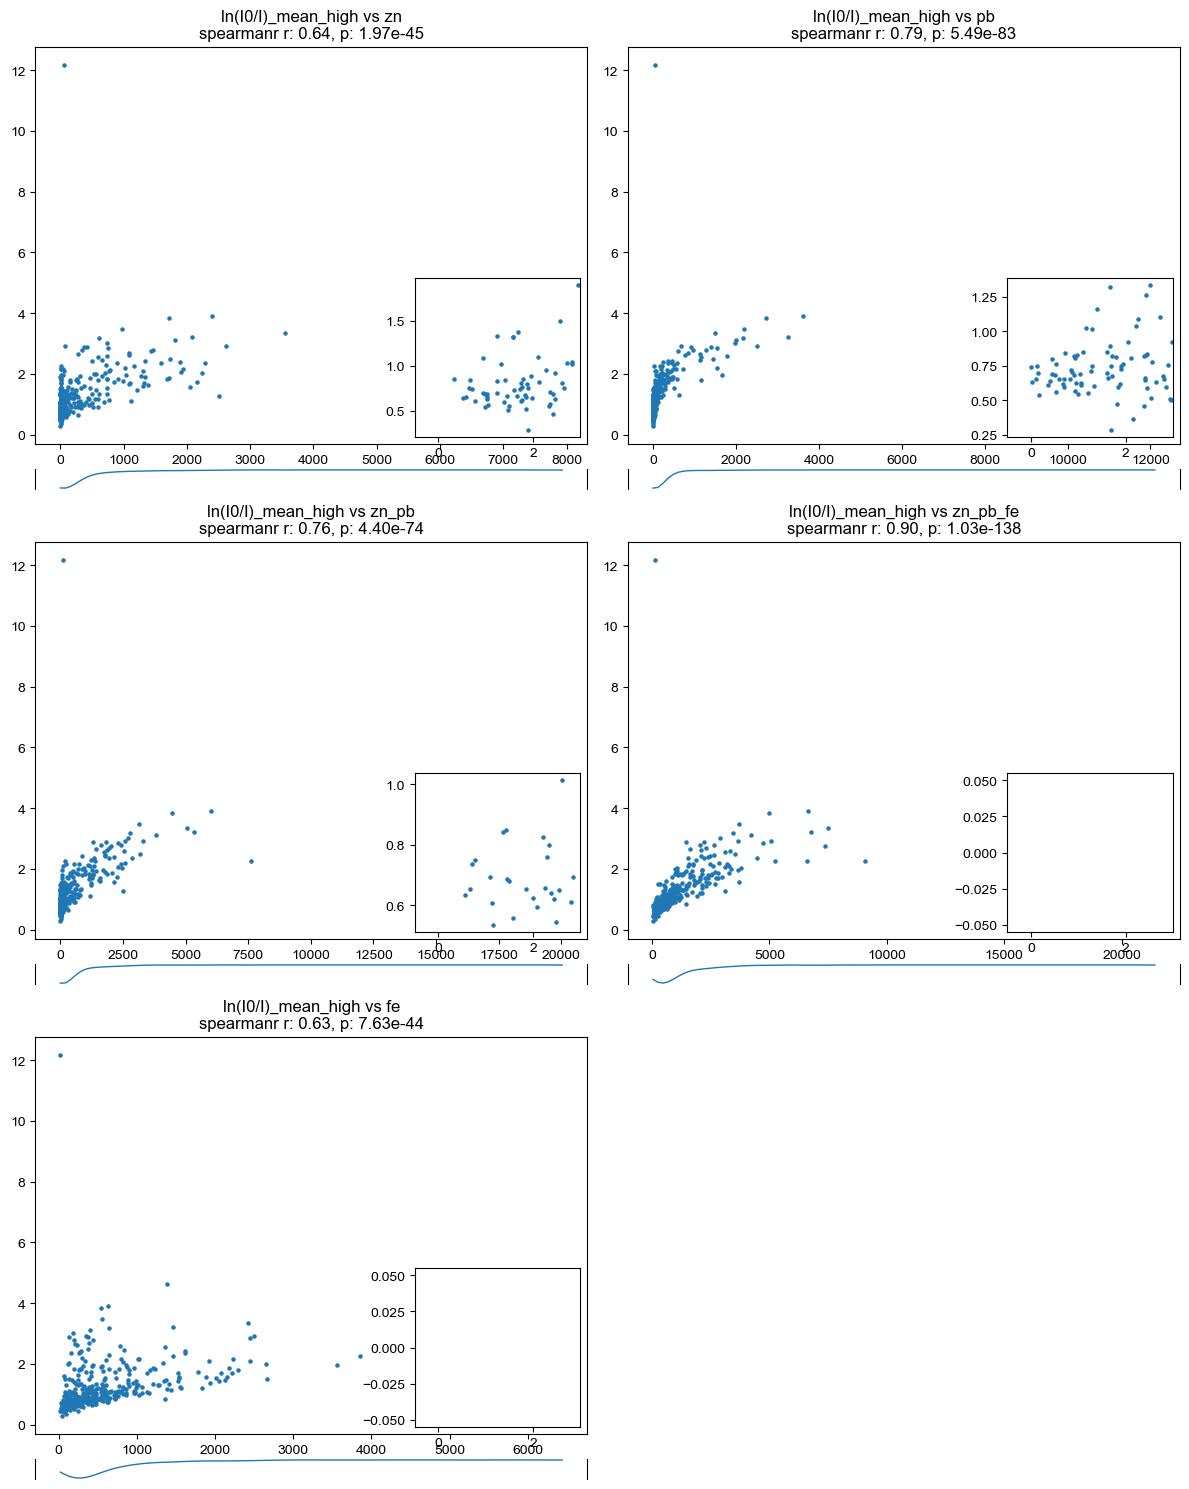

In [205]:
plot_dist([input_all], type = 'log', kind = 'spearmanr', energy = 'high', w = True)

In [107]:
corr, p = pearsonr(fe, sg)
print(corr, p)


0.9186680884718019 1.6680886234557113e-40


In [110]:
corr, p = pearsonr(fe + pb + zn, sg)
print(corr, p)

0.8438627085484933 1.0590547668840818e-27


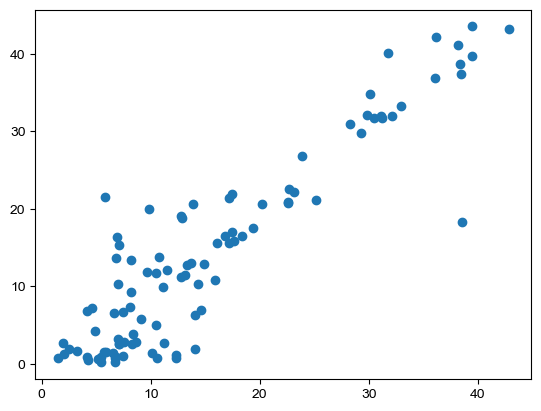

In [ ]:
plt.scatter(fe, sg)


## data plot

/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_79927/2252206831.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_plot.groupby(pd.cut(data_plot['Pb_grade'] + data_plot['Zn_grade'], bins=20))['weight'].mean()


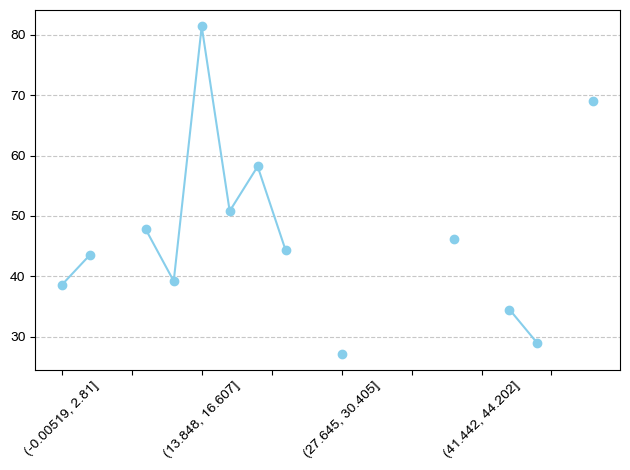

In [11]:
sources = ['source_0']
for source in sources:
    data_plot = data.loc[data['source'] == source]
    data_plot['valuable_metal'] = data_plot['weight'] * (data_plot['Pb_grade'] + data_plot['Zn_grade']) / 100

    # 按重量分组并计算平均有价金属质量
    grouped = data_plot.groupby(pd.cut(data_plot['Pb_grade'] + data_plot['Zn_grade'], bins=20))['weight'].mean()

    # plt.figure(figsize=(10, 6))
    # grouped.plot(kind='bar', color='skyblue')
    grouped.plot(kind='line', marker='o', color='skyblue')

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_48472/2787584442.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_plot.groupby(pd.cut(data_plot['weight'], bins=10))['valuable_metal'].mean()


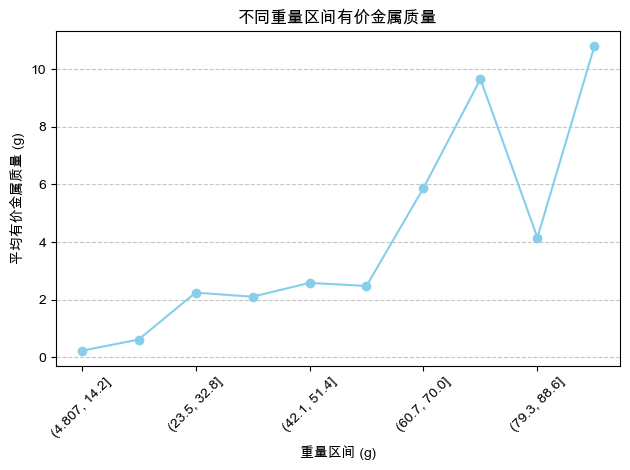

/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_48472/2787584442.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_plot.groupby(pd.cut(data_plot['weight'], bins=10))['valuable_metal'].mean()


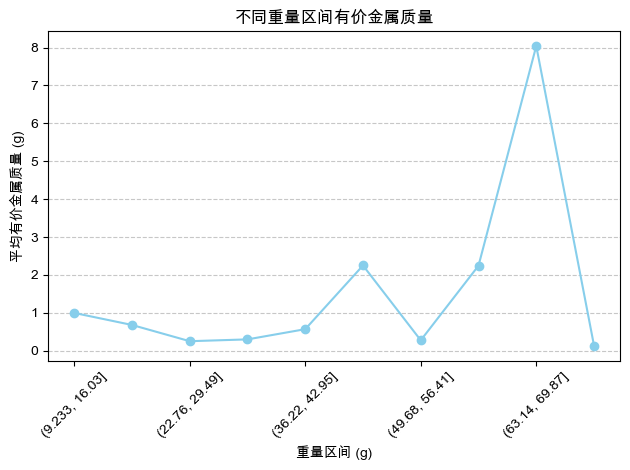

/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_48472/2787584442.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_plot.groupby(pd.cut(data_plot['weight'], bins=10))['valuable_metal'].mean()


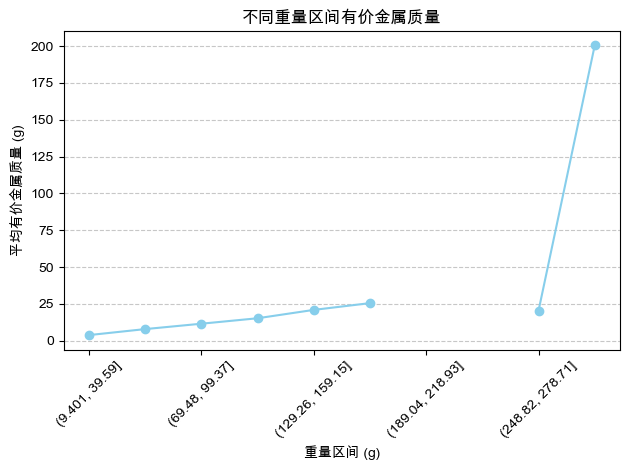

In [60]:
sources = ['source_0', 'source_1', 'source_2']
for source in sources:
    data_plot = data.loc[data['source'] == source]
    data_plot['valuable_metal'] = data_plot['weight'] * (data_plot['Pb_grade'] + data_plot['Zn_grade']) / 100

    # 按重量分组并计算平均有价金属质量
    grouped = data_plot.groupby(pd.cut(data_plot['weight'], bins=10))['valuable_metal'].mean()

    # plt.figure(figsize=(10, 6))
    # grouped.plot(kind='bar', color='skyblue')
    grouped.plot(kind='line', marker='o', color='skyblue')

    plt.title('不同重量区间有价金属质量')
    plt.xlabel('重量区间 (g)')
    plt.ylabel('平均有价金属质量 (g)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## select ore test

In [160]:
with open ('20250422_7_mean_grade_data_v4.pkl', 'rb') as f:
    data_tt= pickle.load(f)

In [166]:
data_tt[0][1].index

Index([294, 119, 223,  11,  39, 309, 249, 250, 331, 159, 375,  80,   7,  75,
       297,  58, 107, 109, 228, 269, 176, 190, 140, 154, 275, 380, 181, 231,
       108, 317,  35,  91, 103, 239,  86,  48, 386, 247, 396, 261, 162,  52,
       335,  62, 125,  25, 246, 117, 395, 235, 198,  89, 347,  13,  17, 254,
       126, 105,  50,  76, 362,  53, 138,  33, 160, 296, 306, 195, 314,  74,
       132, 111, 278, 377,   3, 344, 308, 323, 130, 137, 345, 355, 288, 248,
       384,  32, 157, 170,   1,   4,   6,  10,  23, 352, 183,  43, 174, 303,
        37, 252],
      dtype='int64')

In [171]:
common_indices = data_tt[0][1].index.intersection(data_tt[6][1].index)


In [173]:
# for i in range(len(data)):
    
#     try:
#         assert data_tt[i][1].index.is_unique
#         print(i)
#     except:
#         continue

In [86]:
def select_ores_test(df, N, target_grade, max_iter=1000):
    """
    使用贪心算法选择矿石
    
    参数:
    - df: pandas.DataFrame, 包含列: 'weight', 'pb', 'zn', 'fe'
    - N: int, 需要选择的矿石数量
    - target_grade: float, 目标(Pb+Zn)加权平均品位
    - max_iter: int, 最大迭代次数
    
    返回:
    - selected_df: pandas.DataFrame, 选中的矿石数据
    """

    df = df.copy()
    df['delta'] = abs((df['Pb_grade'] + df['Zn_grade']) - target_grade)
    
    # 初始选择：delta最小的N块矿石
    selected = df.nsmallest(N, 'delta').copy()
    rest = df.drop(selected.index).copy()
    
    def calc_avg(s_df):
        total_weight = s_df['weight'].sum()
        return ((s_df['Pb_grade'] * s_df['weight']).sum() + 
                (s_df['Zn_grade'] * s_df['weight']).sum()) / total_weight
    
    best_diff = abs(calc_avg(selected) - target_grade)
    
    for _ in range(max_iter):
        improved = False
        # 遍历selected的副本，避免修改循环中的集合
        for i in selected.index.copy():
            if improved:
                break
            # 遍历rest的副本
            for j in rest.index.copy():
                try:
                    # 尝试交换i和j
                    new_selected = pd.concat([
                        selected.drop(i),
                        rest.loc[[j]]  # 确保用[[j]]保留DataFrame结构
                    ])
                    new_avg = calc_avg(new_selected)
                    new_diff = abs(new_avg - target_grade)
                    
                    if new_diff < best_diff:
                        # 更新rest：移除j，添加i
                        new_rest = pd.concat([
                            rest.drop(j),
                            selected.loc[[i]]
                        ])
                        # 确认索引同步
                        assert i in new_rest.index, f"矿石{i}未正确添加到rest！"
                        assert j not in new_rest.index, f"矿石{j}未从rest中移除！"
                        
                        # 更新selected和rest
                        selected = new_selected
                        rest = new_rest
                        best_diff = new_diff
                        improved = True
                        break
                except KeyError as e:
                    print(f"交换时出错：{e}，跳过此次交换")
                    continue
        if not improved:
            break
    
    # 验证结果
    assert selected.index.is_unique, "选中的矿石索引重复！"
    assert rest.index.is_unique, "剩余的矿石索引重复！"
    assert len(selected) == N, f"选中的矿石数量不正确：{len(selected)} != {N}"
    
    print(f"目标品位: {target_grade:.4f}, 实际得到: {calc_avg(selected):.4f}")
    return selected.drop(columns=['delta'])

In [87]:
selected = select_ores_test(data, 100, 1)

目标品位: 1.0000, 实际得到: 1.0000


In [88]:
assert selected.index.is_unique

In [90]:
index = selected.index.values
input_i= [[pixels[0][index], pixels[1][index]], data.loc[index]]

In [91]:
index

array([294, 119, 223,  11,  39, 309, 249, 250, 331, 159, 375,  80,   7,
        75, 297,  58, 107, 109, 228, 269, 176, 190, 140, 154, 275, 380,
       181, 231, 108, 317,  35,  91, 103, 239,  86,  48, 386, 247, 396,
       261, 162,  52, 335,  62, 125,  25, 246, 117, 395, 235, 198,  89,
       347,  13,  17, 254, 126, 105,  50,  76, 362,  53, 138,  33, 160,
       296, 306, 195, 314,  74, 132, 111, 278, 377,   3, 344, 308, 323,
       130, 137, 345, 355, 288, 248, 384,  32, 157, 170,   1,   4,   6,
        10,  23, 352, 183,  43, 174, 303,  37, 252])